In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import textstat

# Data download and cleaning

In [ ]:
# Load the fake and true news datasets
fake_df = pd.read_csv("/content/Fake.csv")
true_df = pd.read_csv("/content/True.csv")

# Add a label column: 1 for Fake news, 0 for Real news
fake_df['label'] = 1
true_df['label'] = 0

# Concatenate the two dataframes into one
df = pd.concat([fake_df, true_df], ignore_index=True)

# Drop unnecessary columns (subject and date) to focus on the content
df = df.drop(columns=['subject', 'date'])

# Display the total number of articles loaded
print("Total articles loaded:", len(df))

# Compute article length for each article
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Delete the articles with text length < 50
df = df[df['text_length'] > 49].reset_index(drop=True)
print(f"Total articles loaded:", {len(df)})

Total articles loaded: 44898
Total articles loaded: {42677}


# Exploratory data analysis

In [ ]:
###### EXPLORATORY DATA ANALYSIS ######

# Number of fake and real news articles
class_counts = df['label'].value_counts()
num_fake = class_counts[1]
num_real = class_counts[0]
print(f"Number of fake news articles: {num_fake}")
print(f"Number of real news articles: {num_real}")

# Average, median, and max article length for fake news
fake_lengths = df[df['label'] == 1]['text_length']
avg_length_fake = fake_lengths.mean()
median_length_fake = fake_lengths.median()
max_length_fake = fake_lengths.max()

# Average, median, and max article length for real news
real_lengths = df[df['label'] == 0]['text_length']
avg_length_real = real_lengths.mean()
median_length_real = real_lengths.median()
max_length_real = real_lengths.max()

# Results
print(f"\nFake news articles:")
print(f" - Average length: {avg_length_fake:.2f} words")
print(f" - Median length:  {median_length_fake:.0f} words")
print(f" - Max length:     {max_length_fake} words")

print(f"\nReal news articles:")
print(f" - Average length: {avg_length_real:.2f} words")
print(f" - Median length:  {median_length_real:.0f} words")
print(f" - Max length:     {max_length_real} words")

# Global article length stats
min_length = df['text_length'].min()
max_length = df['text_length'].max()
median_length = df['text_length'].median()
avg_length = df['text_length'].mean()

print(f"\nGlobal article length stats:")
print(f" - Shortest article length: {min_length} words")
print(f" - Longest article length:  {max_length} words")
print(f" - Global median length:    {median_length:.0f} words")
print(f" - Global average length:   {avg_length:.2f} words")


Number of fake news articles: 21586
Number of real news articles: 21091

Fake news articles:
 - Average length: 458.99 words
 - Median length:  381 words
 - Max length:     8135 words

Real news articles:
 - Average length: 390.98 words
 - Median length:  364 words
 - Max length:     5172 words

Global article length stats:
 - Shortest article length: 50 words
 - Longest article length:  8135 words
 - Global median length:    374 words
 - Global average length:   425.38 words


In [ ]:
###### TEXT PREPROCESSING ######

# Combine title and text into one field
df['content'] = df['title'] + " " + df['text']

# Drop the now redundant title and text columns
df = df.drop(columns=['title', 'text'])

# Split the data into training and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 34141
Test set size: 8536


# Model 1 : TF-IDF feature extraction and logistic regression

In [ ]:
###### TF-IDF FEATURE EXTRACTION AND LOGISTIC REGRESSION ######

# Download lemmatizer resources
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define text cleaning function
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized

# Apply cleaning to both train and test sets
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

# Convert to TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)
X_test_tfidf = vectorizer.transform(X_test_cleaned)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate performance
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\nTF-IDF + Logistic Regression Performance:")
print(f"Accuracy:  {acc_lr:.2f}")
print(f"Precision: {prec_lr:.2f}")
print(f"Recall:    {rec_lr:.2f}")
print(f"F1-score:  {f1_lr:.2f}")

# Confusion matrix
cm_df = pd.DataFrame(cm_lr, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



TF-IDF + Logistic Regression Performance:
Accuracy:  0.99
Precision: 0.99
Recall:    0.98
F1-score:  0.99
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            4180              38
Actual Fake              71            4247


In [ ]:
# Checking that everything got vectorized correctly
print(sorted(vectorizer.vocabulary_.keys())[:50])

['aaron', 'abadi', 'abandon', 'abandoned', 'abandoning', 'abbas', 'abbott', 'abc', 'abdel', 'abducted', 'abdul', 'abdullah', 'abe', 'abedin', 'abid', 'abide', 'ability', 'able', 'aboard', 'abolish', 'aborted', 'abortion', 'abraham', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absurd', 'abu', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'aca', 'academic', 'academy', 'accelerate', 'accelerated', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access']


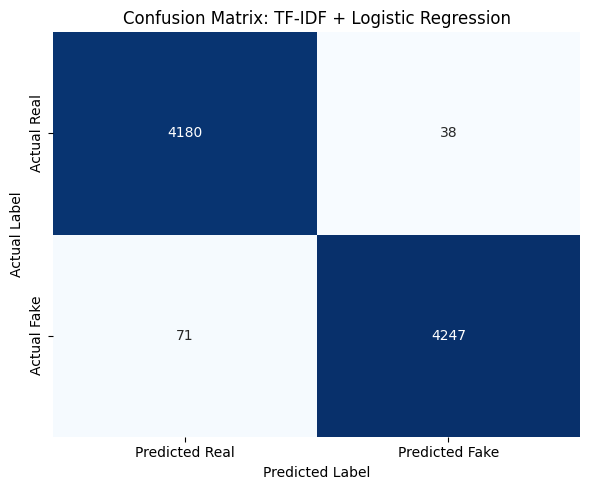

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix: TF-IDF + Logistic Regression")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [ ]:
nltk.download('punkt', download_dir='/root/nltk_data')
nltk.download('punkt_tab', download_dir='/root/nltk_data')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({'word': feature_names, 'coef': coefficients})

top_fake = coef_df.sort_values(by="coef", ascending=False).head(15)
top_real = coef_df.sort_values(by="coef", ascending=True).head(15)

print("Top FAKE words:\n", top_fake)
print("Top REAL words:\n", top_real)

Top FAKE words:
           word      coef
4386     image  8.572217
9586     video  7.895679
4886      just  7.199790
3845       gop  6.088937
4187   hillary  5.565136
2723       don  5.488379
9842      wire  4.926518
6103     obama  4.829183
5835        mr  4.673432
2521      didn  4.523762
2706     doesn  4.403943
342   american  4.346715
9543        ve  4.312668
5221      like  4.200192
341    america  4.159169
Top REAL words:
               word       coef
7586       reuters -24.332640
7805          said -18.697540
9711    washington  -6.070944
9755     wednesday  -5.239452
9272       tuesday  -4.948778
9042      thursday  -4.428029
3668        friday  -4.348992
5769        monday  -3.839785
6071           nov  -3.816418
2732          dont  -3.755471
4385            im  -3.579146
5692      minister  -3.485147
8987         thats  -3.313999
6837  presidential  -3.300705
8441     spokesman  -3.247318


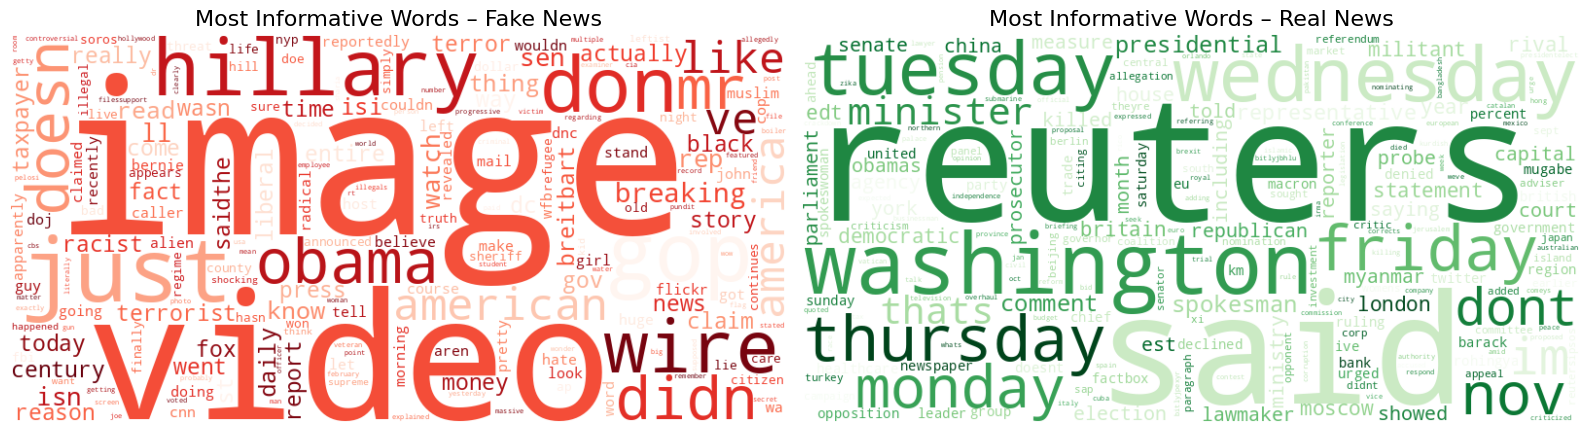

In [ ]:
# WORDCLOUD

feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

coef_dict = dict(zip(feature_names, coefficients))

fake_words = {word: abs(weight) for word, weight in coef_dict.items() if weight > 0}
real_words = {word: abs(weight) for word, weight in coef_dict.items() if weight < 0}

fake_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds')
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens')

fake_wc.generate_from_frequencies(fake_words)
real_wc.generate_from_frequencies(real_words)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Informative Words – Fake News', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Informative Words – Real News', fontsize=16)

plt.tight_layout()
plt.show()

# Model 2 : Stylistic features and random forest

In [ ]:
###### STYLISTIC FEATURES AND RANDOM FOREST ######

# Download the Punkt tokenizer for sentence splitting
nltk.download('punkt')

# Function to extract stylistic features from a single text string
def extract_style_features(text):
    # Light cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Number of words
    words = text.split()
    num_words = len(words)
    # Number of alphanumeric characters in the text
    total_alnum = sum(ch.isalnum() for ch in text)
    # Number of uppercase letters in the text
    uppercase_count = sum(ch.isupper() for ch in text)
    # Number of letters in the text
    total_letters = sum(ch.isalpha() for ch in text)
    # Count specific punctuation
    exclamation_count = text.count('!')
    question_count = text.count('?')
    # Total punctuation count
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)
    # Number of sentences (using NLTK sentence tokenizer)
    sentences = nltk.tokenize.sent_tokenize(text)
    num_sentences = len(sentences) if len(sentences) > 0 else 1
    # Calculate features
    avg_word_len = total_alnum / num_words if num_words > 0 else 0
    avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0
    uppercase_ratio = uppercase_count / total_letters if total_letters > 0 else 0
    # Unique word ratio
    text_lower = text.lower()
    text_lower = re.sub(r'[^a-z0-9\s]', '', text_lower)
    tokens = text_lower.split()
    unique_ratio = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0
    # Return all features as a list
    return [avg_word_len, avg_sentence_len, punctuation_count, uppercase_ratio,
            exclamation_count, question_count, unique_ratio]

# Define feature names for clarity
feature_names = ["avg_word_length", "avg_sentence_length", "punctuation_count",
                 "uppercase_ratio", "exclamation_count", "question_count", "unique_word_ratio"]

# Extract features for each article in the training set
X_train_style = [extract_style_features(text) for text in X_train]
X_train_style = pd.DataFrame(X_train_style, columns=feature_names)

# Extract features for each article in the test set
X_test_style = [extract_style_features(text) for text in X_test]
X_test_style = pd.DataFrame(X_test_style, columns=feature_names)

# Train a Random Forest classifier on the stylistic features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_style, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_style)

# Evaluate the Random Forest model
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nStylistic Features + Random Forest Performance:")
print(f"Accuracy:  {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall:    {rec_rf:.2f}")
print(f"F1-score:  {f1_rf:.2f}")
cm_df_rf = pd.DataFrame(cm_rf, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df_rf)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Stylistic Features + Random Forest Performance:
Accuracy:  0.90
Precision: 0.90
Recall:    0.91
F1-score:  0.91
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            3784             434
Actual Fake             389            3929


In [ ]:
###### STYLISTIC FEATURES AND RANDOM FOREST (+ stopword ratio) ######
# Here we add a stopword ratio

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stopword_set = set(stopwords.words('english'))

# Function to extract stylistic features
def extract_style_features(text):
    # Light cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    num_words = len(words)
    total_alnum = sum(ch.isalnum() for ch in text)
    total_letters = sum(ch.isalpha() for ch in text)
    uppercase_count = sum(ch.isupper() for ch in text)
    exclamation_count = text.count('!')
    question_count = text.count('?')
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)

    # Sentence-level
    sentences = nltk.tokenize.sent_tokenize(text)
    num_sentences = len(sentences) if len(sentences) > 0 else 1
    avg_word_len = total_alnum / num_words if num_words > 0 else 0
    avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0
    uppercase_ratio = uppercase_count / total_letters if total_letters > 0 else 0

    # Lexical diversity
    text_lower = text.lower()
    text_clean = re.sub(r'[^a-z0-9\s]', '', text_lower)
    tokens = text_clean.split()
    unique_ratio = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

    # New: stopword ratio
    num_stopwords = sum(1 for word in tokens if word in stopword_set)
    stopword_ratio = num_stopwords / len(tokens) if len(tokens) > 0 else 0

    return [avg_word_len, avg_sentence_len, punctuation_count, uppercase_ratio,
            exclamation_count, question_count, unique_ratio, stopword_ratio]

# Updated feature list
feature_names = [
    "avg_word_length", "avg_sentence_length", "punctuation_count", "uppercase_ratio",
    "exclamation_count", "question_count", "unique_word_ratio", "stopword_ratio"
]

# Extract features
X_train_style = pd.DataFrame([extract_style_features(text) for text in X_train], columns=feature_names)
X_test_style = pd.DataFrame([extract_style_features(text) for text in X_test], columns=feature_names)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_style, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_style)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nStylistic Features (+ stopword ratio) + Random Forest Performance:")
print(f"Accuracy:  {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall:    {rec_rf:.2f}")
print(f"F1-score:  {f1_rf:.2f}")

cm_df_rf = pd.DataFrame(cm_rf, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df_rf)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Stylistic Features (+ stopword ratio) + Random Forest Performance:
Accuracy:  0.94
Precision: 0.93
Recall:    0.96
F1-score:  0.94
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            3910             308
Actual Fake             189            4129


In [ ]:
###### STYLISTIC FEATURES AND RANDOM FOREST (+ all-caps words) ######

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stopword_set = set(stopwords.words('english'))

# Feature extraction function
def extract_style_features(text):
    # Light cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    num_words = len(words)
    total_alnum = sum(ch.isalnum() for ch in text)
    total_letters = sum(ch.isalpha() for ch in text)
    uppercase_count = sum(ch.isupper() for ch in text)
    exclamation_count = text.count('!')
    question_count = text.count('?')
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)

    # Sentence-level
    sentences = nltk.tokenize.sent_tokenize(text)
    num_sentences = len(sentences) if len(sentences) > 0 else 1
    avg_word_len = total_alnum / num_words if num_words > 0 else 0
    avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0
    uppercase_ratio = uppercase_count / total_letters if total_letters > 0 else 0

    # Lexical diversity
    text_lower = text.lower()
    text_clean = re.sub(r'[^a-z0-9\s]', '', text_lower)
    tokens = text_clean.split()
    unique_ratio = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

    # Stopword ratio
    num_stopwords = sum(1 for word in tokens if word in stopword_set)
    stopword_ratio = num_stopwords / len(tokens) if len(tokens) > 0 else 0

    # New: all-caps word count
    all_caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)

    return [
        avg_word_len, avg_sentence_len, punctuation_count, uppercase_ratio,
        exclamation_count, question_count, unique_ratio, stopword_ratio, all_caps_words
    ]

# Updated feature list
feature_names = [
    "avg_word_length", "avg_sentence_length", "punctuation_count", "uppercase_ratio",
    "exclamation_count", "question_count", "unique_word_ratio", "stopword_ratio",
    "all_caps_words"
]

# Extract features
X_train_style = pd.DataFrame([extract_style_features(text) for text in X_train], columns=feature_names)
X_test_style = pd.DataFrame([extract_style_features(text) for text in X_test], columns=feature_names)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_style, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_style)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nStylistic Features (+ stopword ratio + ALL CAPS words) + Random Forest:")
print(f"Accuracy:  {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall:    {rec_rf:.2f}")
print(f"F1-score:  {f1_rf:.2f}")

cm_df_rf = pd.DataFrame(cm_rf, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df_rf)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Stylistic Features (+ stopword ratio + ALL CAPS words) + Random Forest:
Accuracy:  0.94
Precision: 0.93
Recall:    0.96
F1-score:  0.95
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            3920             298
Actual Fake             176            4142


In [ ]:
###### STYLISTIC FEATURES AND RANDOM FOREST (+ avg chars per sentence) ######

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stopword_set = set(stopwords.words('english'))

# Feature extraction function
def extract_style_features(text):
    # Light cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    num_words = len(words)
    total_alnum = sum(ch.isalnum() for ch in text)
    total_letters = sum(ch.isalpha() for ch in text)
    uppercase_count = sum(ch.isupper() for ch in text)
    exclamation_count = text.count('!')
    question_count = text.count('?')
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)

    # Sentence-level
    sentences = nltk.tokenize.sent_tokenize(text)
    num_sentences = len(sentences) if len(sentences) > 0 else 1
    avg_word_len = total_alnum / num_words if num_words > 0 else 0
    avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0
    uppercase_ratio = uppercase_count / total_letters if total_letters > 0 else 0

    # New: average number of characters per sentence (excluding whitespace)
    total_chars = sum(len(s.replace(" ", "")) for s in sentences)
    avg_chars_per_sentence = total_chars / num_sentences if num_sentences > 0 else 0

    # Lexical diversity
    text_lower = text.lower()
    text_clean = re.sub(r'[^a-z0-9\s]', '', text_lower)
    tokens = text_clean.split()
    unique_ratio = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

    # Stopword ratio
    num_stopwords = sum(1 for word in tokens if word in stopword_set)
    stopword_ratio = num_stopwords / len(tokens) if len(tokens) > 0 else 0

    # All-caps word count
    all_caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)

    return [
        avg_word_len, avg_sentence_len, punctuation_count, uppercase_ratio,
        exclamation_count, question_count, unique_ratio, stopword_ratio,
        all_caps_words, avg_chars_per_sentence
    ]

# Updated feature list
feature_names = [
    "avg_word_length", "avg_sentence_length", "punctuation_count", "uppercase_ratio",
    "exclamation_count", "question_count", "unique_word_ratio", "stopword_ratio",
    "all_caps_words", "avg_chars_per_sentence"
]

# Extract features
X_train_style = pd.DataFrame([extract_style_features(text) for text in X_train], columns=feature_names)
X_test_style = pd.DataFrame([extract_style_features(text) for text in X_test], columns=feature_names)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_style, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_style)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nStylistic Features (+ stopword + ALL CAPS + char/sentence) + Random Forest:")
print(f"Accuracy:  {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall:    {rec_rf:.2f}")
print(f"F1-score:  {f1_rf:.2f}")

cm_df_rf = pd.DataFrame(cm_rf, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df_rf)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Stylistic Features (+ stopword + ALL CAPS + char/sentence) + Random Forest:
Accuracy:  0.94
Precision: 0.93
Recall:    0.96
F1-score:  0.94
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            3920             298
Actual Fake             186            4132


In [ ]:
!pip install textstat

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Stylistic Features (+ readability) + Random Forest Performance:
Accuracy:  0.95
Precision: 0.93
Recall:    0.96
F1-score:  0.95
Confusion Matrix:
             Predicted Real  Predicted Fake
Actual Real            3922             296
Actual Fake             165            4153


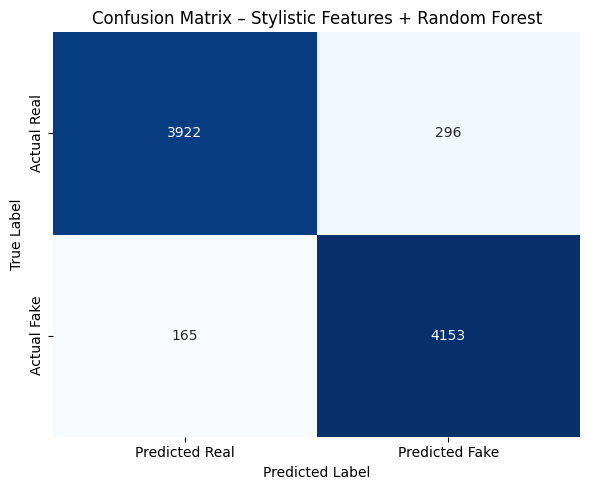

In [ ]:
###### STYLISTIC FEATURES AND RANDOM FOREST (+ readability score) ######

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

# Feature extraction function
def extract_style_features(text):
    # Light cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    num_words = len(words)
    total_alnum = sum(ch.isalnum() for ch in text)
    total_letters = sum(ch.isalpha() for ch in text)
    uppercase_count = sum(ch.isupper() for ch in text)
    exclamation_count = text.count('!')
    question_count = text.count('?')
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)

    # Sentence-level
    sentences = nltk.tokenize.sent_tokenize(text)
    num_sentences = len(sentences) if len(sentences) > 0 else 1
    avg_word_len = total_alnum / num_words if num_words > 0 else 0
    avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0
    uppercase_ratio = uppercase_count / total_letters if total_letters > 0 else 0

    # Avg characters per sentence (excluding whitespace)
    total_chars = sum(len(s.replace(" ", "")) for s in sentences)
    avg_chars_per_sentence = total_chars / num_sentences if num_sentences > 0 else 0

    # Lexical diversity
    text_lower = text.lower()
    text_clean = re.sub(r'[^a-z0-9\s]', '', text_lower)
    tokens = text_clean.split()
    unique_ratio = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

    # Stopword ratio
    num_stopwords = sum(1 for word in tokens if word in stopword_set)
    stopword_ratio = num_stopwords / len(tokens) if len(tokens) > 0 else 0

    # All-caps word count
    all_caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)

    # New: Readability (Flesch Reading Ease)
    readability = textstat.flesch_reading_ease(text)

    return [
        avg_word_len, avg_sentence_len, punctuation_count, uppercase_ratio,
        exclamation_count, question_count, unique_ratio, stopword_ratio,
        all_caps_words, avg_chars_per_sentence, readability
    ]

# Updated feature list
feature_names = [
    "avg_word_length", "avg_sentence_length", "punctuation_count", "uppercase_ratio",
    "exclamation_count", "question_count", "unique_word_ratio", "stopword_ratio",
    "all_caps_words", "avg_chars_per_sentence", "readability"
]

# Extract features
X_train_style = pd.DataFrame([extract_style_features(text) for text in X_train], columns=feature_names)
X_test_style = pd.DataFrame([extract_style_features(text) for text in X_test], columns=feature_names)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_style, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_style)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nStylistic Features (+ readability) + Random Forest Performance:")
print(f"Accuracy:  {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall:    {rec_rf:.2f}")
print(f"F1-score:  {f1_rf:.2f}")

cm_df_rf = pd.DataFrame(cm_rf, index=['Actual Real', 'Actual Fake'], columns=['Predicted Real', 'Predicted Fake'])
print("Confusion Matrix:")
print(cm_df_rf)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

cm_df_rf = pd.DataFrame(cm_rf,
                        index=['Actual Real', 'Actual Fake'],
                        columns=['Predicted Real', 'Predicted Fake'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix – Stylistic Features + Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


<ipython-input-20-b2684fd00213>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


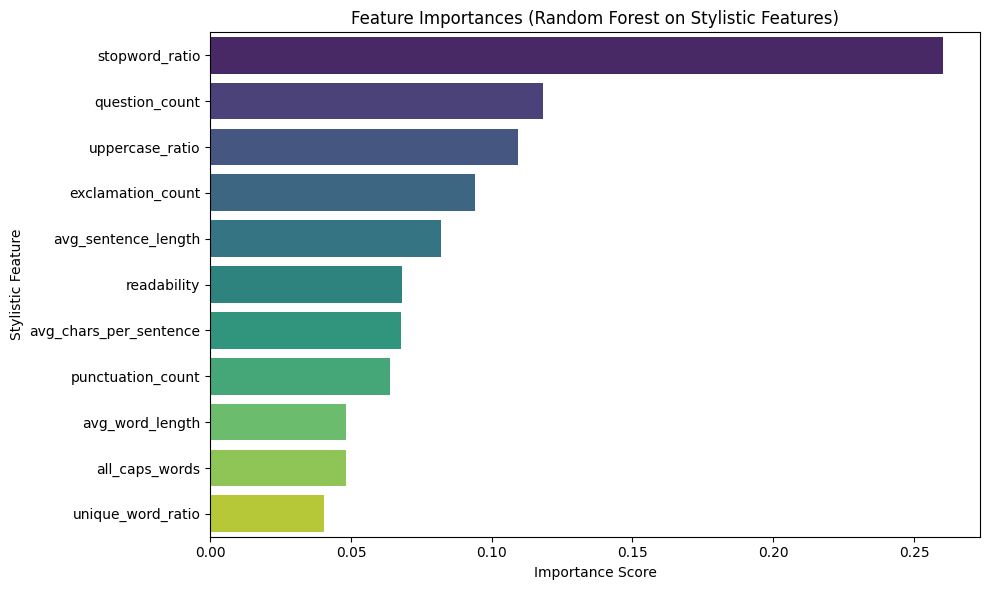

In [ ]:
# Feature importances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances (Random Forest on Stylistic Features)")
plt.xlabel("Importance Score")
plt.ylabel("Stylistic Feature")
plt.tight_layout()
plt.show()


# Model 3 : Bert and fine-tuning

In [ ]:
!pip install transformers scikit-learn pandas seaborn

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3: 100%|██████████| 4490/4490 [56:15<00:00,  1.33it/s, loss=7.75e-7]



Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000


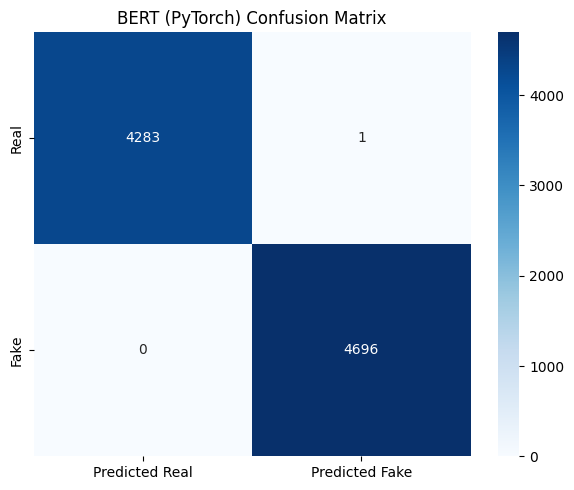

In [ ]:
##### BERT #####
#This code takes approximately 3 hours to run

X_train, X_test, y_train, y_test = train_test_split(df["content"], df["label"], test_size=0.2, stratify=df["label"])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(labels.values)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(X_train, y_train, tokenizer)
test_dataset = NewsDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
model.train()
for epoch in range(3):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"\nAccuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=["Real", "Fake"], columns=["Predicted Real", "Predicted Fake"]),
            annot=True, fmt="d", cmap="Blues")
plt.title("BERT (PyTorch) Confusion Matrix")
plt.tight_layout()
plt.show()
